# Ames, Iowa : Predicting Sales Prices - Penalized Linear Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler,\
MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from LR_helper import cat_column_combine_vars, num_new_features,\
label_encode_features, model_results, cat_new_features, std_num_cols
from yellowbrick.regressor import PredictionError, ResidualsPlot
from statsmodels.stats.diagnostic import normal_ad
from clean_helper import dtype_update
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

### Loading cleaned training and testing datasets:-

In [2]:
train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)
print(train_df.shape)
print(test_df.shape)

(1453, 80)
(1457, 79)


- Creating copies to apply diffrent transformations and engineering techniques:

In [3]:
train_df_cpy = train_df.copy()
test_df_cpy = test_df.copy()
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 80)
(1457, 79)


### Creating new numerical variables, combining variables and creating new categorical variables:-

In [4]:
# Creating new numerical variable features:-
num_new_features(train_df)
num_new_features(test_df)
num_new_features(train_df_cpy)
num_new_features(test_df_cpy)

# Combining categories in some categorical features:-
cat_column_combine_vars(train_df)
cat_column_combine_vars(test_df)
cat_column_combine_vars(train_df_cpy)
cat_column_combine_vars(test_df_cpy)

# Creating new categorical variable features:-
cat_new_features(train_df)
cat_new_features(test_df)
cat_new_features(train_df_cpy)
cat_new_features(test_df_cpy)

In [5]:
print(train_df.shape)
print(test_df.shape)
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 88)
(1457, 87)
(1453, 88)
(1457, 87)


### In-depth EDA to research relationship with Sales Price

#### 1. Finished Basement relation to Sale Prices

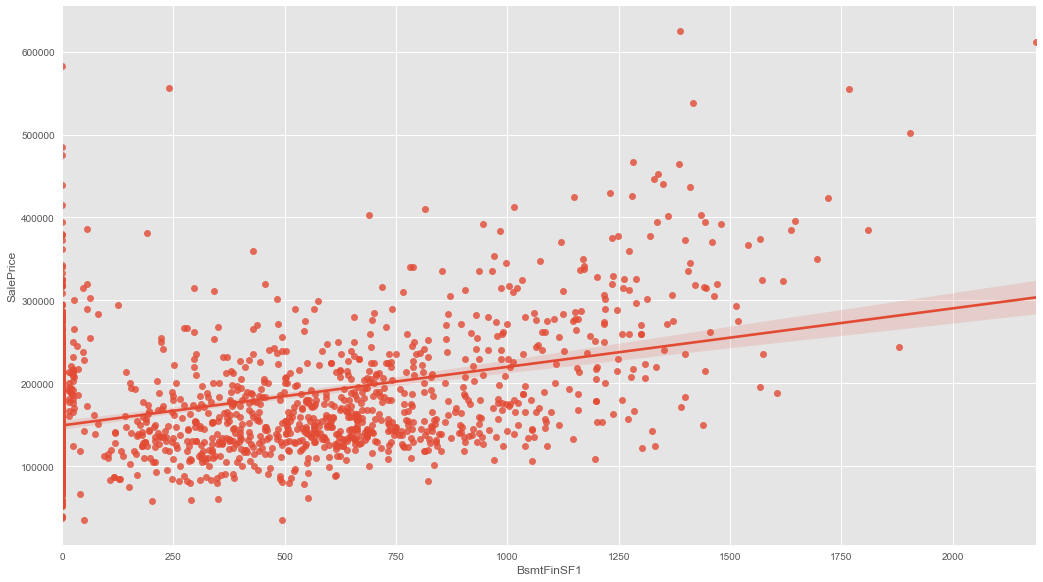

In [6]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

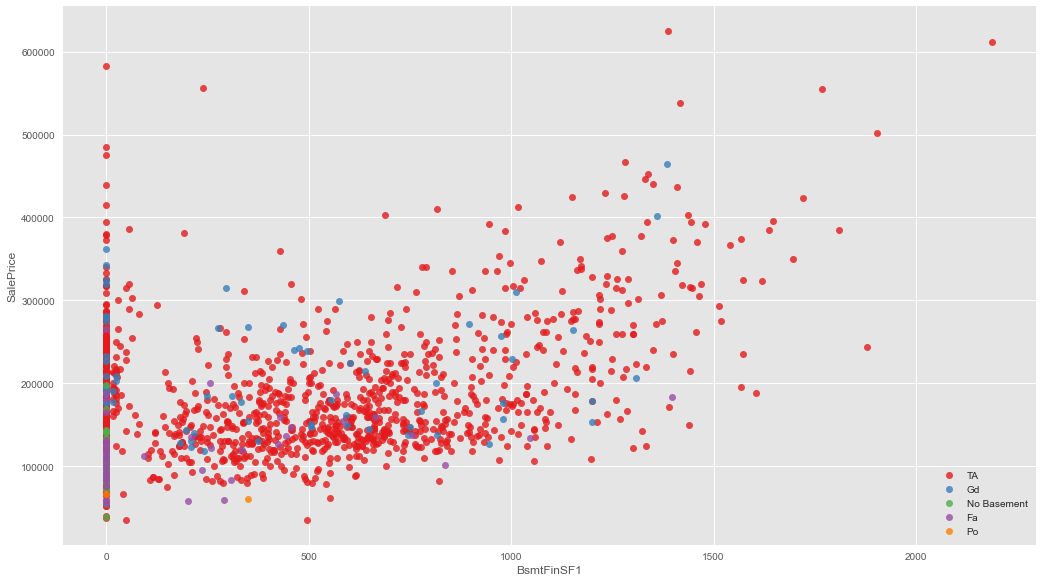

In [7]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtCond', legend=False)
plt.legend(loc='lower right')

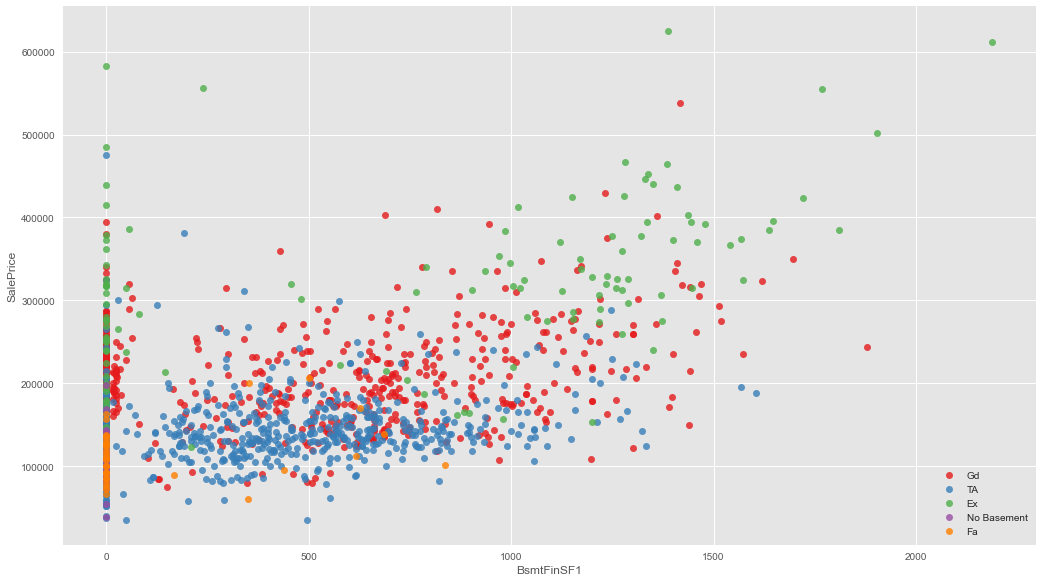

In [8]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtQual', legend=False)
plt.legend(loc='lower right')

#### 2. Above ground living area

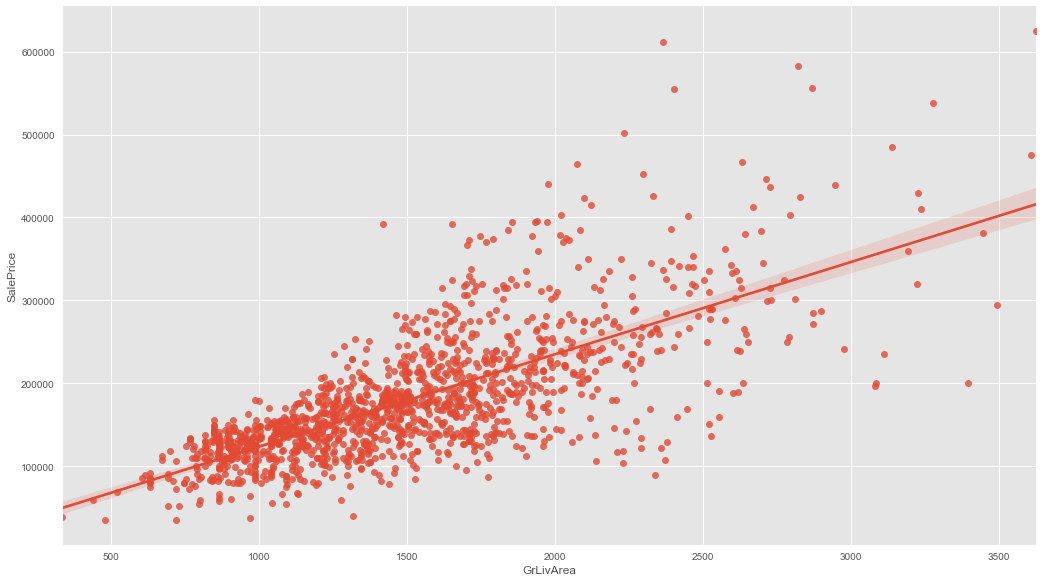

In [9]:
sns.lmplot("GrLivArea", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

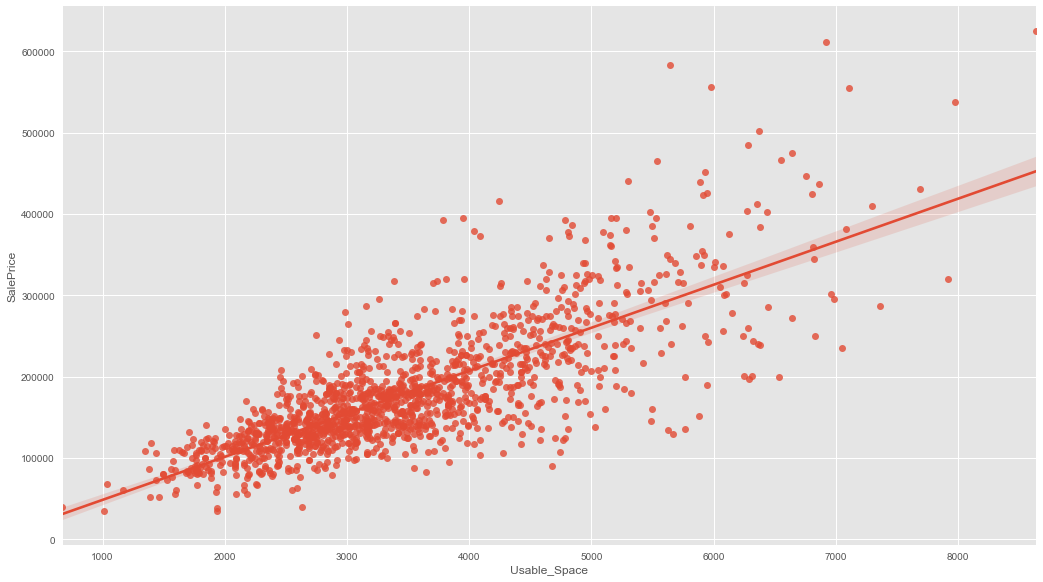

In [10]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

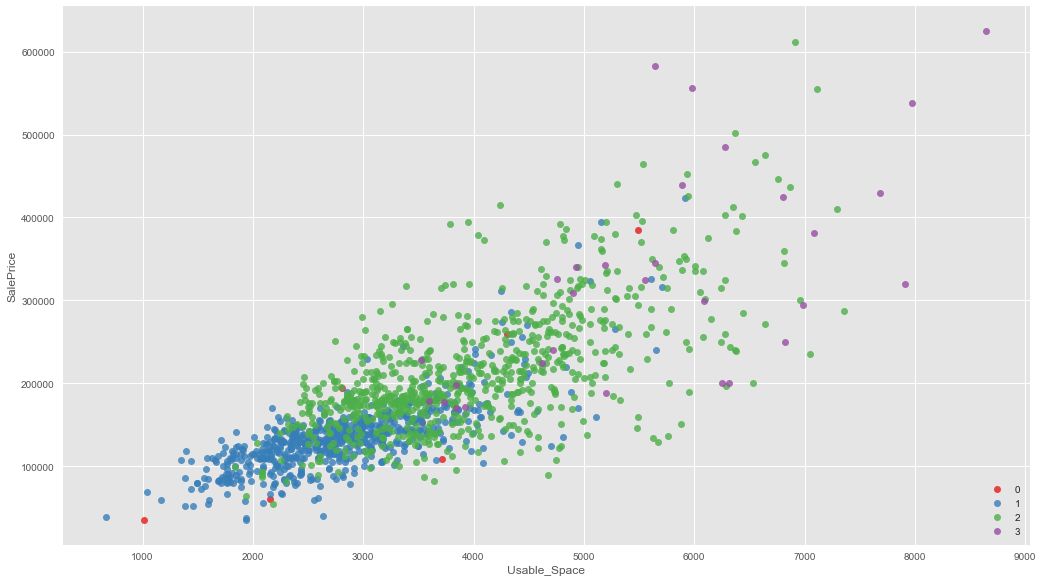

In [11]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='FullBath', legend=False)
plt.legend(loc='lower right')

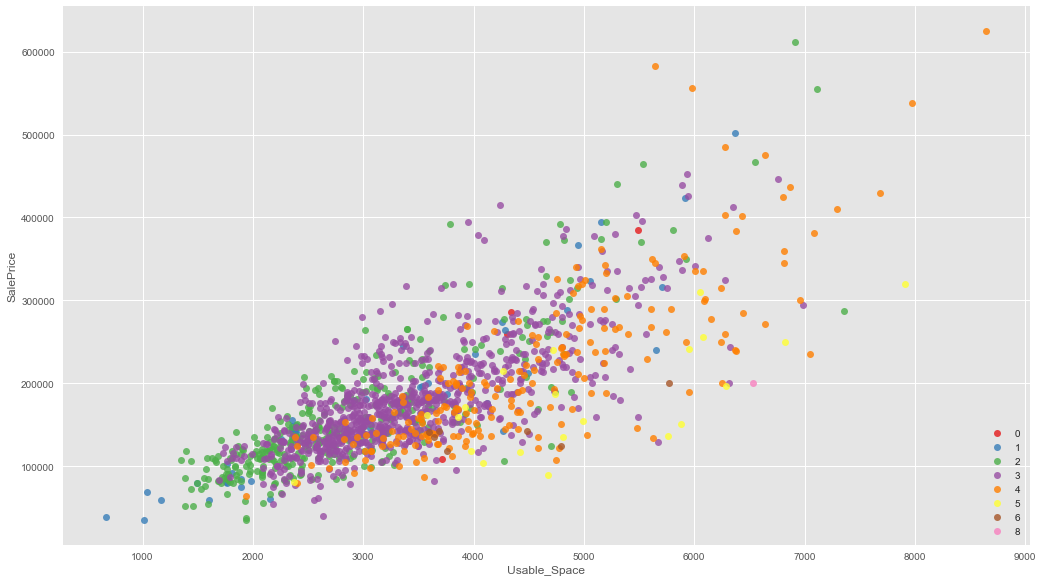

In [12]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BedroomAbvGr', legend=False)
plt.legend(loc='lower right')

#### 4. Years since remodeled and remodeled or not

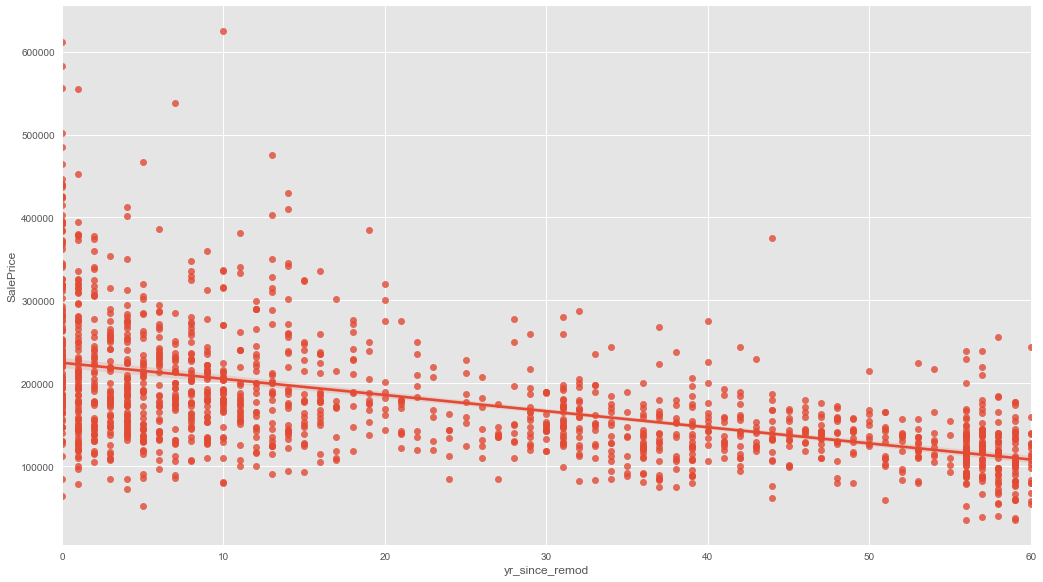

In [13]:
sns.lmplot("yr_since_remod", "SalePrice", train_df, height=8, aspect=1.8, palette="Pastel1")

Text(0.5, 1.0, 'House Price vs Years Since Remodeled')

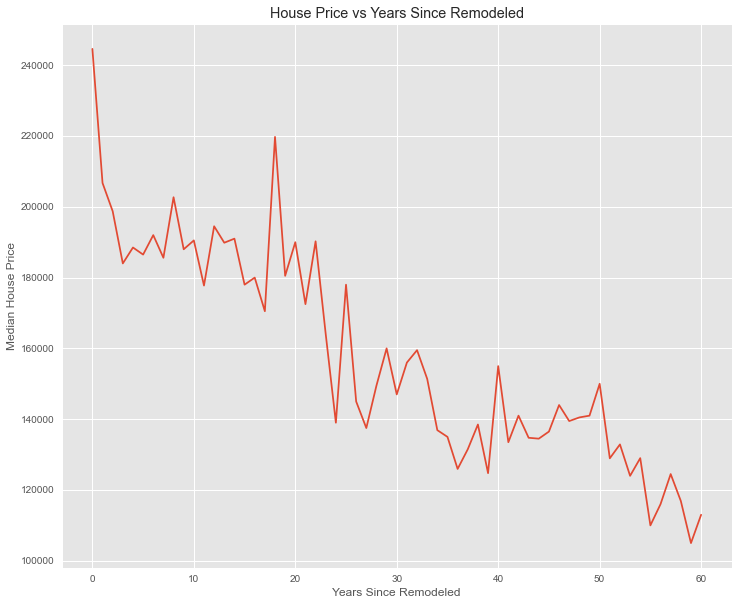

In [14]:
plt.figure(figsize = (12,10))
train_df.groupby('yr_since_remod')['SalePrice'].median().plot()
plt.xlabel('Years Since Remodeled')
plt.ylabel('Median House Price')
plt.title("House Price vs Years Since Remodeled")

<AxesSubplot:xlabel='remod_y_n', ylabel='SalePrice'>

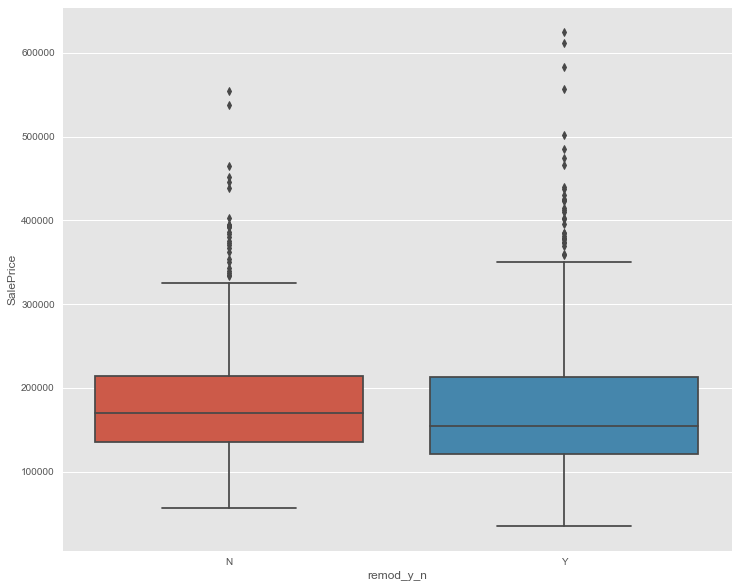

In [15]:
plt.figure(figsize = (12,10))
my_order = train_df.groupby('remod_y_n')['SalePrice']\
           .median().sort_values(ascending=False).index
sns.boxplot(data=train_df, x='remod_y_n', y='SalePrice', order=my_order)

### Label encoding categorical features (all dataframes):

In [16]:
#Label encoding via helper functions:-

label_encode_features(train_df)
label_encode_features(test_df)
label_encode_features(train_df_cpy)
label_encode_features(test_df_cpy)

### OneHot encoding categorical features (all dataframes):

In [17]:
col_list = ['Street', 'Alley', 'LandContour','RoofStyle','Exterior1st','MSZoning',\
            'Utilities', 'LotConfig','Neighborhood', 'Condition1', 'Condition2',\
            'BldgType', 'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Foundation','MasVnrType',\
            'CentralAir','Heating', 'Electrical', 'Functional','Exterior2nd','GarageType',\
            'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',\
            'SaleType', 'SaleCondition','remod_y_n', 'HouseStyle', 'MSSubClass']

train_df = pd.get_dummies(data=train_df, columns=col_list, drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=col_list, drop_first=True)

train_df_cpy = pd.get_dummies(data=train_df_cpy, columns=col_list, drop_first=True)
test_df_cpy = pd.get_dummies(data=test_df_cpy, columns=col_list, drop_first=True)

### Standardizing numerical columns:

- Only for the copies of test and train dfs

In [18]:
std_num_cols(train_df_cpy)
std_num_cols(test_df_cpy)

## Ridge Regression Models:-

In [19]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

## Separating x and y variables for test-train split (copy df)

house_x_cpy = train_df_cpy.drop(['SalePrice'], axis=1)
house_y_cpy = train_df_cpy['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)
trainXcp, testXcp, trainYcp, testYcp = train_test_split(house_x_cpy, house_y_cpy, random_state=42, test_size=0.3)

### 1. Adjusting standardization/normalisation and alpha levels

In [20]:
# Numerical columns standardized:

ridge_base12 = Ridge()
model_results(trainXcp, trainYcp, testXcp, testYcp, ridge_base12, show = True)

Train R^2 is equal to 0.948
Test R^2 is equal to 0.875
The intercept is -52730.009
RSS is equal to 323530906525.948
RMSE is equal to 17835.998
The training error is: 0.05208
The test     error is: 0.12486


[0.05207656708342401, 0.1248632933167334]

In [21]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base11 = Ridge()
model_results(trainX, trainY, testX, testY, ridge_base11, show = True)

Train R^2 is equal to 0.948
Test R^2 is equal to 0.875
The intercept is -52730.009
RSS is equal to 323530906525.948
RMSE is equal to 17835.998
The training error is: 0.05208
The test     error is: 0.12486


[0.05207656708342401, 0.1248632933167334]

In [22]:
# Numerical columns not standardized (normalization is turned on):

ridge_base13 = Ridge()
ridge_base13.set_params(normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base13, show = True)

Train R^2 is equal to 0.916
Test R^2 is equal to 0.887
The intercept is -64280.126
RSS is equal to 520635563664.171
RMSE is equal to 22625.930
The training error is: 0.08380
The test     error is: 0.11262


[0.08380316164631707, 0.11262098279840627]

In [23]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base14 = Ridge()
ridge_base14.set_params(alpha = 0, normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base14, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to -30556349903389218308096.000
The intercept is -172907337426370080.000
RSS is equal to 302761009342.000
RMSE is equal to 17253.988
The training error is: 0.04873
The test     error is: 30556349903389218308096.00000


[0.04873337815711687, 3.055634990338922e+22]

### 2. Log-transforming y variable only:

In [24]:
# Numerical columns standardized:

ridge_base22 = Ridge()
model_results(trainXcp, np.log(trainYcp), testXcp, np.log(testYcp), ridge_base22, show = True)

Train R^2 is equal to 0.959
Test R^2 is equal to 0.893
The intercept is 10.874
RSS is equal to 6.557
RMSE is equal to 0.080
The training error is: 0.04053
The test     error is: 0.10697


[0.04052962948695327, 0.10696836075327854]

In [25]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base21 = Ridge()
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base21, show = True)

Train R^2 is equal to 0.959
Test R^2 is equal to 0.893
The intercept is 10.874
RSS is equal to 6.557
RMSE is equal to 0.080
The training error is: 0.04053
The test     error is: 0.10697


[0.04052962948695327, 0.10696836075327854]

In [26]:
# Numerical columns not standardized (normalization is turned on):

ridge_base23 = Ridge()
ridge_base23.set_params(normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base23, show = True)

Train R^2 is equal to 0.930
Test R^2 is equal to 0.894
The intercept is 10.455
RSS is equal to 11.270
RMSE is equal to 0.105
The training error is: 0.06966
The test     error is: 0.10566


[0.06966425032875789, 0.10566404647041949]

In [27]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base24 = Ridge()
ridge_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base24, show = True)

Train R^2 is equal to 0.963
Test R^2 is equal to -18020244051114623762432.000
The intercept is -707046504454.602
RSS is equal to 6.023
RMSE is equal to 0.077
The training error is: 0.03723
The test     error is: 18020244051114623762432.00000


[0.037227320463188884, 1.8020244051114624e+22]

### 3. Log-transforming x and y variables:

In [28]:
# Applying log-transformation on the x features (both datasets)

trfm = FunctionTransformer(func=np.log1p)

trainX_trans = trfm.fit_transform(trainX)
trainXcp_trans = trfm.fit_transform(trainXcp)
testX_trans = trfm.fit_transform(testX)
testXcp_trans = trfm.fit_transform(testXcp)

In [29]:
# Numerical columns standardized:

ridge_base32 = Ridge()
model_results(trainXcp_trans, np.log(trainYcp), testXcp_trans, np.log(testYcp), ridge_base32, show = True)

Train R^2 is equal to 0.954
Test R^2 is equal to 0.897
The intercept is 6.096
RSS is equal to 7.513
RMSE is equal to 0.086
The training error is: 0.04644
The test     error is: 0.10341


[0.046437721335038096, 0.1034074703648401]

In [30]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base31 = Ridge()
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base31, show = True)

Train R^2 is equal to 0.954
Test R^2 is equal to 0.897
The intercept is 6.096
RSS is equal to 7.513
RMSE is equal to 0.086
The training error is: 0.04644
The test     error is: 0.10341


[0.046437721335038096, 0.1034074703648401]

In [31]:
# Numerical columns not standardized (normalization is turned on):

ridge_base33 = Ridge()
ridge_base33.set_params(normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base33, show = True)

Train R^2 is equal to 0.925
Test R^2 is equal to 0.888
The intercept is 3.523
RSS is equal to 12.059
RMSE is equal to 0.109
The training error is: 0.07454
The test     error is: 0.11189


[0.07454177743084822, 0.11188962277526726]

In [32]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base34 = Ridge()
ridge_base34.set_params(alpha = 0, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base34, show = True)

Train R^2 is equal to 0.961
Test R^2 is equal to -527529799159543798693888.000
The intercept is -5527650012110.889
RSS is equal to 6.389
RMSE is equal to 0.079
The training error is: 0.03949
The test     error is: 527529799159543798693888.00000


[0.039493949791243765, 5.275297991595438e+23]

### Visualzing errors for first three models of the last section

- Numerical columns are standardized in this model:

(array([  3.,   2.,   1.,   6.,  43., 196., 505., 220.,  35.,   6.]),
 array([-0.57564938, -0.48684179, -0.3980342 , -0.30922661, -0.22041902,
        -0.13161143, -0.04280384,  0.04600375,  0.13481134,  0.22361893,
         0.31242652]),
 <BarContainer object of 10 artists>)

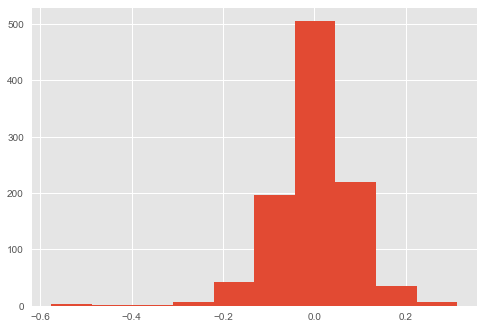

In [33]:
residuals = np.log(trainYcp) - ridge_base32.predict(trainXcp_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is not turned on

(array([  3.,   2.,   1.,   6.,  43., 196., 505., 220.,  35.,   6.]),
 array([-0.57564938, -0.48684179, -0.3980342 , -0.30922661, -0.22041902,
        -0.13161143, -0.04280384,  0.04600375,  0.13481134,  0.22361893,
         0.31242652]),
 <BarContainer object of 10 artists>)

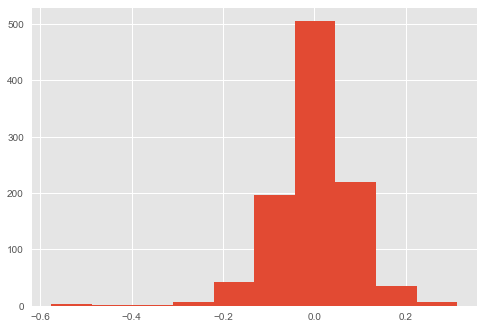

In [34]:
residuals = np.log(trainY) - ridge_base31.predict(trainX_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is turned on

(array([  3.,   2.,   6.,  19.,  78., 353., 410., 123.,  17.,   6.]),
 array([-0.64702164, -0.54044804, -0.43387444, -0.32730084, -0.22072723,
        -0.11415363, -0.00758003,  0.09899357,  0.20556718,  0.31214078,
         0.41871438]),
 <BarContainer object of 10 artists>)

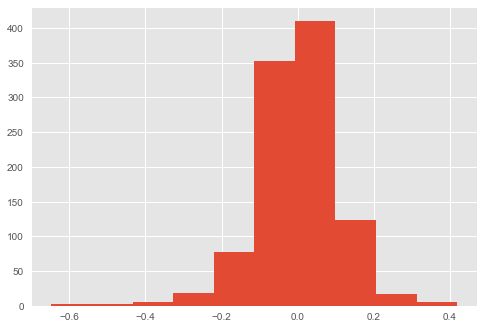

In [35]:
residuals = np.log(trainY) - ridge_base33.predict(trainX_trans)
plt.hist(residuals)

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [36]:
alphas = np.arange(0,20)
scores = []

for alpha in alphas:
        ridge_base32.set_params(alpha=alpha)
        ridge_base32.fit(trainXcp_trans, np.log(trainYcp))  
        scores.append(ridge_base32.score(trainXcp_trans, np.log(trainYcp)))

Text(0, 0.5, '$R^2$')

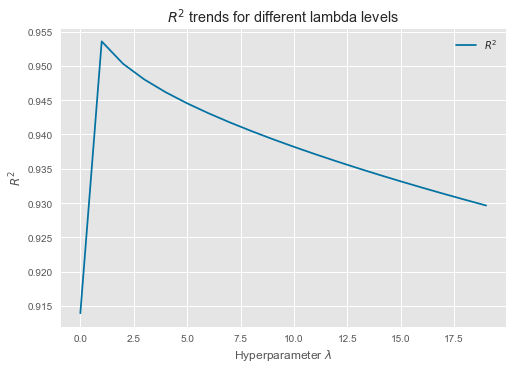

In [37]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [38]:
alphas = np.arange(0,20)
ridge_base33.set_params(normalize=True)
scores = []

for alpha in alphas:
        ridge_base33.set_params(alpha=alpha)
        ridge_base33.fit(trainX_trans, np.log(trainY))  
        scores.append(ridge_base33.score(trainX_trans, np.log(trainY)))

Text(0, 0.5, '$R^2$')

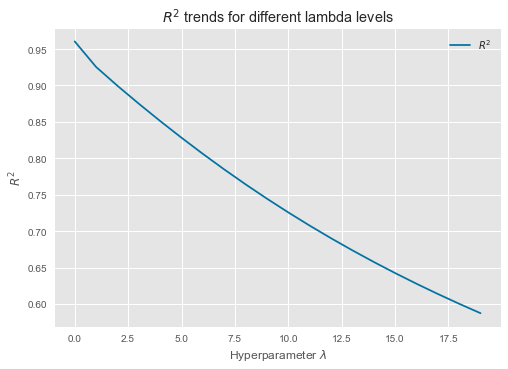

In [39]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Using Grid Search CV to fing the optimum alpha:

In [40]:
ridge_final_1 = ridge_base31
ridge_final_2 = ridge_base33.set_params(normalize=True)

In [41]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0.01,100,10)}

# Initiating the Grid Search
grid1 = GridSearchCV(ridge_final_1, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_ridge1 = grid1.fit(trainX_trans, np.log(trainY))

In [42]:
## The best parameter is
ans_ridge1.best_params_

{'alpha': 11.12}

In [43]:
## The best score is
ans_ridge1.best_score_

0.9071524673248584

In [44]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0.01,100,10)}

# Initiating the Grid Search
grid2 = GridSearchCV(ridge_final_2, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_ridge2 = grid2.fit(trainX_trans, np.log(trainY))

In [45]:
## The best parameter is
ans_ridge2.best_params_

{'alpha': 0.01}

In [46]:
## The best score is
ans_ridge2.best_score_

0.8606872219642989

## Final Ridge Regression models:

In [47]:
# Numerical columns not standardized (normalization is not turned on):

ridge_fin1 = Ridge()
ridge_fin1.set_params(alpha=11.12)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_fin1, show = True)

Train R^2 is equal to 0.937
Test R^2 is equal to 0.906
The intercept is 6.841
RSS is equal to 10.193
RMSE is equal to 0.100
The training error is: 0.06301
The test     error is: 0.09396


[0.06300750102638619, 0.09395763597416407]

(array([  3.,   2.,   4.,  14.,  68., 304., 481., 120.,  18.,   3.]),
 array([-0.63397234, -0.53082233, -0.42767232, -0.32452231, -0.2213723 ,
        -0.11822228, -0.01507227,  0.08807774,  0.19122775,  0.29437776,
         0.39752777]),
 <BarContainer object of 10 artists>)

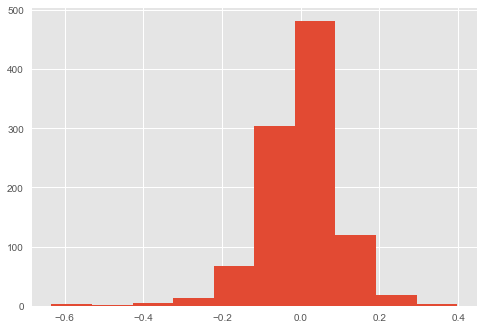

In [48]:
# Plotting the residuals

residuals = np.log(trainY) - ridge_fin1.predict(trainX_trans)
plt.hist(residuals)

In [49]:
# Numerical columns not standardized (normalization is turned on):

ridge_fin2 = Ridge()
ridge_fin2.set_params(alpha=0.01, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_fin2, show = True)

Train R^2 is equal to 0.959
Test R^2 is equal to 0.876
The intercept is 9.996
RSS is equal to 6.681
RMSE is equal to 0.081
The training error is: 0.04130
The test     error is: 0.12435


[0.041296116447745335, 0.12435150329845046]

(array([  2.,   3.,   1.,   4.,  33., 162., 504., 256.,  44.,   8.]),
 array([-0.56970359, -0.48350261, -0.39730163, -0.31110066, -0.22489968,
        -0.1386987 , -0.05249772,  0.03370325,  0.11990423,  0.20610521,
         0.29230618]),
 <BarContainer object of 10 artists>)

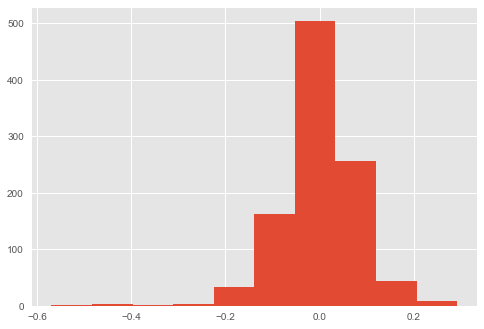

In [50]:
# Plotting the residuals

residuals = np.log(trainY) - ridge_fin2.predict(trainX_trans)
plt.hist(residuals)

## Lasso Regression Models:-

In [51]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

## Separating x and y variables for test-train split (copy df)

house_x_cpy = train_df_cpy.drop(['SalePrice'], axis=1)
house_y_cpy = train_df_cpy['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)
trainXcp, testXcp, trainYcp, testYcp = train_test_split(house_x_cpy, house_y_cpy, random_state=42, test_size=0.3)

### 1. Adjusting standardization/normalisation and alpha levels

In [52]:
# Numerical columns standardized:

lasso_base12 = Lasso()
model_results(trainXcp, trainYcp, testXcp, testYcp, lasso_base12, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to 0.853
The intercept is -165517.146
RSS is equal to 302977740864.589
RMSE is equal to 17260.163
The training error is: 0.04877
The test     error is: 0.14677


[0.04876826395457101, 0.14677100270715215]

In [53]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base11 = Lasso()
model_results(trainX, trainY, testX, testY, lasso_base11, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to 0.853
The intercept is -165517.146
RSS is equal to 302977740864.589
RMSE is equal to 17260.163
The training error is: 0.04877
The test     error is: 0.14677


[0.04876826395457101, 0.14677100270715215]

In [54]:
# Numerical columns not standardized (normalization is turned on):

lasso_base13 = Lasso()
lasso_base13.set_params(normalize=True)
model_results(trainX, trainY, testX, testY, lasso_base13, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to 0.860
The intercept is -203500.337
RSS is equal to 307361279836.059
RMSE is equal to 17384.576
The training error is: 0.04947
The test     error is: 0.13975


[0.0494738523750462, 0.13974655034264694]

In [55]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base24 = Lasso()
lasso_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base24, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to -30556349903389218308096.000
The intercept is -172907337426370080.000
RSS is equal to 302761009342.000
RMSE is equal to 17253.988
The training error is: 0.04873
The test     error is: 30556349903389218308096.00000


[0.04873337815711687, 3.055634990338922e+22]

### 2. Log-transforming y variable only:

In [56]:
# Numerical columns standardized:

lasso_base22 = Lasso()
model_results(trainXcp, np.log(trainYcp), testXcp, np.log(testYcp), lasso_base22, show = True)

Train R^2 is equal to 0.820
Test R^2 is equal to 0.819
The intercept is 11.116
RSS is equal to 29.131
RMSE is equal to 0.169
The training error is: 0.18006
The test     error is: 0.18071


[0.180063460193705, 0.180705678467723]

In [57]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base21 = Lasso()
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base21, show = True)

Train R^2 is equal to 0.820
Test R^2 is equal to 0.819
The intercept is 11.116
RSS is equal to 29.131
RMSE is equal to 0.169
The training error is: 0.18006
The test     error is: 0.18071


[0.180063460193705, 0.180705678467723]

In [58]:
# Numerical columns not standardized (normalization is turned on):

lasso_base23 = Lasso()
lasso_base23.set_params(normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base23, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
RMSE is equal to 0.399
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [59]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base24 = Lasso()
lasso_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base24, show = True)

Train R^2 is equal to 0.963
Test R^2 is equal to 0.873
The intercept is 10.890
RSS is equal to 6.018
RMSE is equal to 0.077
The training error is: 0.03720
The test     error is: 0.12728


[0.03719946353381742, 0.12727656175564317]

### 3. Log-transforming x and y variables:

In [60]:
# Applying log-transformation on the x features (both datasets)

trfm = FunctionTransformer(func=np.log1p)

trainX_trans = trfm.fit_transform(trainX)
trainXcp_trans = trfm.fit_transform(trainXcp)
testX_trans = trfm.fit_transform(testX)
testXcp_trans = trfm.fit_transform(testXcp)

In [61]:
# Numerical columns standardized:

lasso_base32 = Lasso()
model_results(trainXcp_trans, np.log(trainYcp), testXcp_trans, np.log(testYcp), lasso_base32, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
RMSE is equal to 0.399
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [62]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base31 = Lasso()
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base31, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
RMSE is equal to 0.399
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [63]:
# Numerical columns not standardized (normalization is turned on):

lasso_base33 = Lasso()
lasso_base33.set_params(normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base33, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
RMSE is equal to 0.399
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [64]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base34 = Lasso()
lasso_base34.set_params(alpha = 0, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base34, show = True)

Train R^2 is equal to 0.960
Test R^2 is equal to 0.858
The intercept is 15.231
RSS is equal to 6.396
RMSE is equal to 0.079
The training error is: 0.03953
The test     error is: 0.14185


[0.03953286192214145, 0.14184904647743724]

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [65]:
alphas = np.arange(0,20)
lasso_base34.set_params(normalize=True)
scores = []

for alpha in alphas:
        lasso_base34.set_params(alpha=alpha)
        lasso_base34.fit(trainX_trans, np.log(trainY))  
        scores.append(lasso_base34.score(trainX_trans, np.log(trainY)))

Text(0, 0.5, '$R^2$')

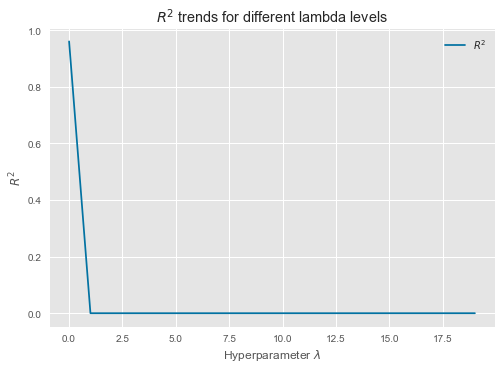

In [66]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Using Grid Search CV to fing the optimum alpha:

In [67]:
lasso_final = lasso_base34.set_params(normalize=True)

In [68]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0,2,20)}

# Initiating the Grid Search
grid = GridSearchCV(lasso_final, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_lasso = grid.fit(trainX_trans, np.log(trainY))

In [69]:
## The best parameter is
ans_lasso.best_params_

{'alpha': 0.0}

In [70]:
## The best score is
ans_lasso.best_score_

0.8351243237995213

## Final Lasso Regression model:

In [71]:
# Numerical columns not standardized (normalization is not turned on):

lasso_fin = Lasso()
lasso_fin.set_params(alpha=0.0006, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_fin, show = True)

Train R^2 is equal to 0.899
Test R^2 is equal to 0.887
The intercept is 4.168
RSS is equal to 16.382
RMSE is equal to 0.127
The training error is: 0.10126
The test     error is: 0.11253


[0.10126162073549583, 0.11252503602234165]

(array([  2.,   2.,   3.,   8.,  59., 136., 504., 250.,  46.,   7.]),
 array([-0.82936224, -0.702819  , -0.57627576, -0.44973253, -0.32318929,
        -0.19664606, -0.07010282,  0.05644041,  0.18298365,  0.30952688,
         0.43607012]),
 <BarContainer object of 10 artists>)

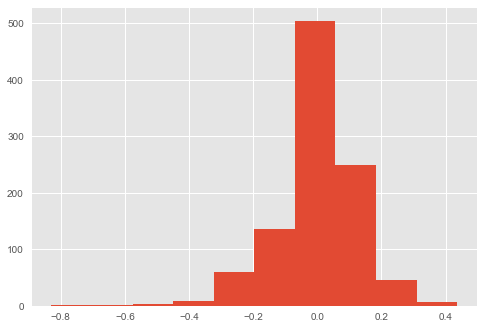

In [72]:
# Plotting the residuals

residuals = np.log(trainY) - lasso_fin.predict(trainX_trans)
plt.hist(residuals)

# Visualizing results

## Final Ridge Regression model:

- Residual plots:

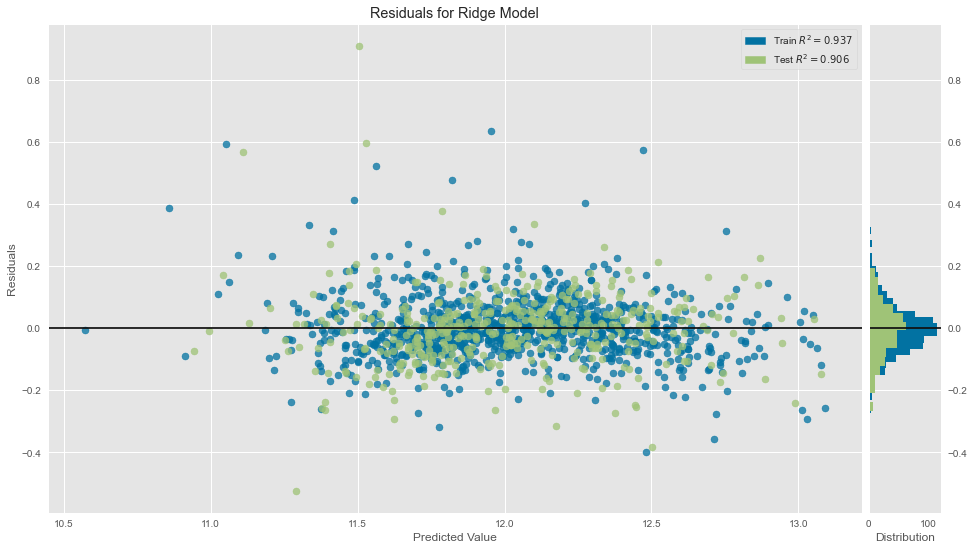

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [73]:
plt.figure(figsize = (16,9))
visualizer2 = ResidualsPlot(ridge_fin1.set_params(alpha=11.12))
visualizer2.fit(trainX_trans, np.log(trainY))
visualizer2.score(testX_trans, np.log(testY))
visualizer2.poof()

## Final Lasso Regression model:

- Residual plots:

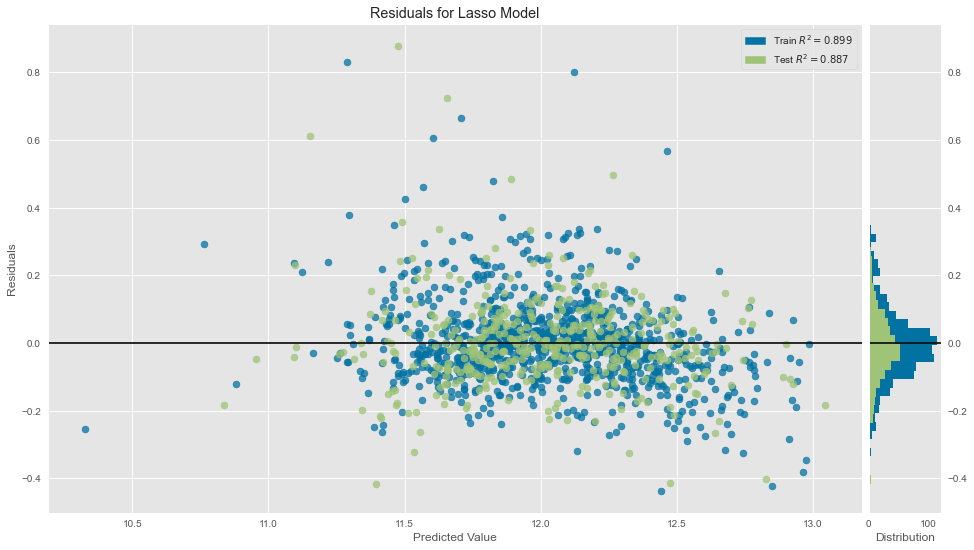

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [74]:
plt.figure(figsize = (16,9))
visualizer4 = ResidualsPlot(lasso_fin.set_params(alpha=0.0006, normalize=True))
visualizer4.fit(trainX_trans, np.log(trainY))
visualizer4.score(testX_trans, np.log(testY))
visualizer4.poof()

## Final Ridge Regression model:

- Residual plots:

In [75]:
# Creating columns needed for assumption graphs:

ridge_fin = Ridge()
ridge_fin = ridge_fin1.set_params(alpha=11.12)

trainX['house_sales_pred'] = ridge_fin.predict(trainX_trans)
trainX['actual_sales'] = np.log(trainY)
trainX['residual'] = trainX['actual_sales'] - trainX['house_sales_pred']

<Figure size 1440x1440 with 0 Axes>

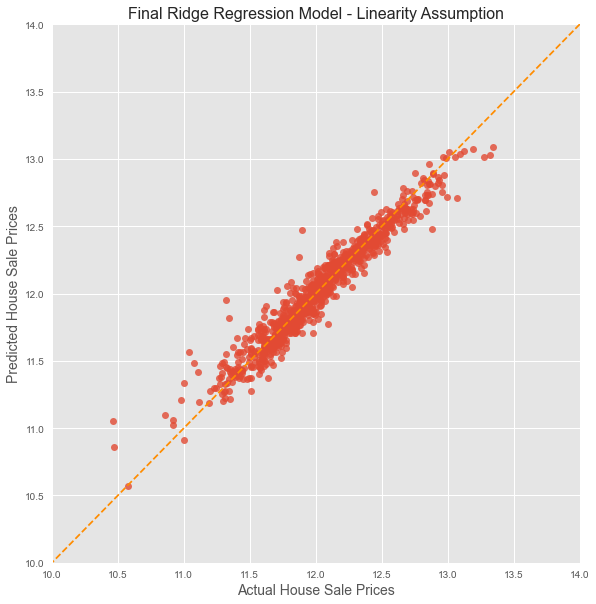

In [76]:
# Plotting the observed vs predicted values

plt.figure(figsize=(20, 20))
sns.lmplot(x='actual_sales', y='house_sales_pred', data=trainX, palette="Set2", fit_reg=False, size=8)
    
# Plotting the diagonal line

line_coords = np.arange(trainX[['actual_sales', 'house_sales_pred']].min().min()-2, 
                        trainX[['actual_sales', 'house_sales_pred']].max().max()+2)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

# Labeling and graph adjustment

plt.ylabel('Predicted House Sale Prices', fontsize=14)
plt.xlabel('Actual House Sale Prices', fontsize=14)
plt.title('Final Ridge Regression Model - Linearity Assumption', fontsize=16)
plt.xlim(10, 14)
plt.ylim(10, 14)
plt.show()

In [77]:
# Performing the Anderson- Darling test on the residuals

p_value = normal_ad(trainX['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 1.789335076376296e-29


## Final Lasso Regression model:

- Residual plots:

In [78]:
# Creating columns needed for assumption graphs:

trainX['house_sales_pred'] = lasso_fin.predict(trainX_trans)
trainX['actual_sales'] = np.log(trainY)
trainX['residual'] = trainX['actual_sales'] - trainX['house_sales_pred']

<Figure size 1440x1440 with 0 Axes>

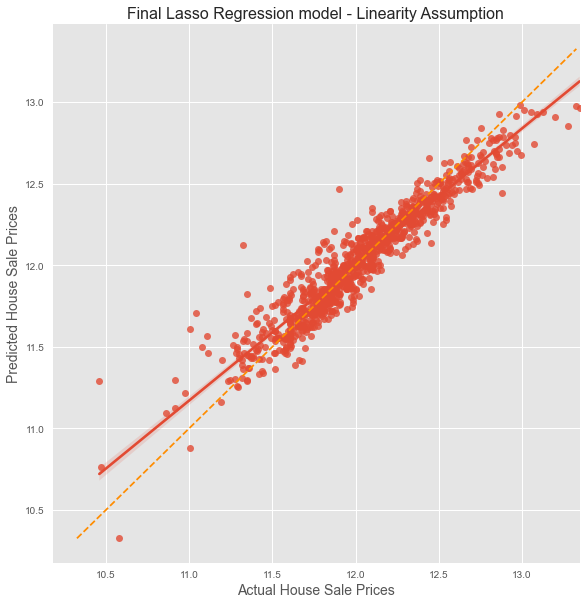

In [79]:
# Plotting the observed vs predicted values

plt.figure(figsize=(20, 20))
sns.lmplot(x='actual_sales', y='house_sales_pred', data=trainX, palette="Set2", fit_reg=True, size=8)
    
# # Plotting the diagonal line

line_coords = np.arange(trainX[['actual_sales', 'house_sales_pred']].min().min(), 
                        trainX[['actual_sales', 'house_sales_pred']].max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

# Labeling and graph adjustment

plt.ylabel('Predicted House Sale Prices', fontsize=14)
plt.xlabel('Actual House Sale Prices', fontsize=14)
plt.title('Final Lasso Regression model - Linearity Assumption', fontsize=16)
plt.show()

In [80]:
# Performing the Anderson- Darling test on the residuals

p_value = normal_ad(trainX['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 0.0
